In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

df = pd.read_csv('C:\\Users\\Square Bear\\Documents\\Thinkful\\Datasets\\WELLCOME.csv', encoding='Latin-1')

df.head(3)

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
0,NaN,CUP,Psychological Medicine,Reduced parahippocampal cortical thickness in ...,£0.00
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",£642.56


In [2]:
df.describe()

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
count,1928,2127,2126,2127,2127
unique,1880,299,984,2126,1402
top,-,Elsevier,PLoS One,"Exclusive breastfeeding, diarrhoel morbidity a...",£2040.00
freq,7,387,92,2,94


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


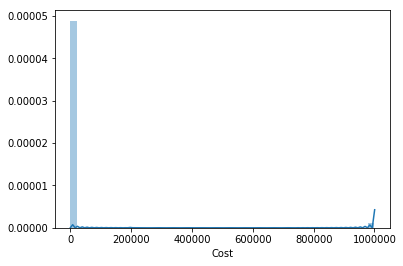

In [3]:
#Drops the PMID/PMCID column.
data = df.drop('PMID/PMCID',axis=1) 
#Renames columns for ease of reference.
data.rename(columns={'Journal title': 'Journal', 'Article title':'Article', 'COST (£) charged to Wellcome (inc VAT when charged)':'Cost'}, inplace=True) 
#Drops any NA values  in any of the columns.
data = data.dropna(subset=['Publisher','Journal','Article'])
#Removes all currency symbol occurrences. 
data.Cost = data.Cost.map(lambda x: x.lstrip('£$').rstrip('£$')) 

#Checks data type by series. 
data.dtypes
#Converts cost into a float: publisher, journal, and article are already strings.
data.Cost = data.Cost.map(lambda x: float(x))

#Removes all string columns leading/trailing whitespace.
data.Publisher = data.Publisher.map(lambda x: x.strip())
data.Journal = data.Journal.map(lambda x: x.strip())
data.Article = data.Article.map(lambda x: x.strip())

#Removes all non-alphanumeric, non-hyphen characters from all string columns.
data.Publisher = data.Publisher.str.extract("([a-zA-Z0-9:\(\)\+/&,\-]*)",expand=True)

#Converts string columns to all-capital case.
data.Publisher = data.Publisher.str.upper()
data.Journal = data.Journal.str.upper()
data.Article = data.Article.str.upper()

#Checks the distribution of cost to determine plausibility and identify winsorization candidates.
plt.show(sns.distplot(data.Cost))
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
data.sort_values(by='Cost',inplace=True)

In [4]:
data.head()


,Publisher,Journal,Article,Cost
0,CUP,PSYCHOLOGICAL MEDICINE,REDUCED PARAHIPPOCAMPAL CORTICAL THICKNESS IN ...,0.00
243,BIOMED,VETERINARY RESEARCH,UNDERSTANDING FOOT-AND-MOUTH DISEASE VIRUS TRA...,9.93
100,AMERICAN,AMERICAN SOCIETY FOR NUTRITION,THE ASSOCIATION BETWEEN BREASTFEEDING AND HIV ...,45.94
1469,PUBLIC,PLOS ONE,HOW WELL ARE MALARIA MAPS USED TO DESIGN AND ...,122.31
1677,SCIEDU,JOURNAL OF BIOMEDICAL GRAPHICS AND COMPUTING,FUNCTIONAL MRI DEMONSTRATES PAIN PERCEPTION IN...,135.29


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


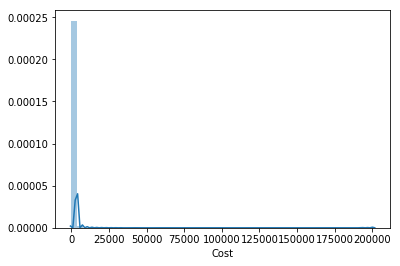

In [5]:
#Store in variables, don't hard-code. 
lower = data.Cost.quantile(0.05)
upper = data.Cost.quantile(0.95)
data.Cost.replace(to_replace=[0.00,999999.00], value=[lower, upper], inplace=True)
data.sort_values(by='Cost',inplace=True)
plt.show(sns.distplot(data.Cost))

In [6]:
common = data.groupby('Journal')[['Article']].count().sort_values(by=['Article'],ascending=False)
common.columns = ['Article Count']
common.head(5)

,Article Count
Journal,
PLOS ONE,190
JOURNAL OF BIOLOGICAL CHEMISTRY,53
NEUROIMAGE,29
NUCLEIC ACIDS RESEARCH,26
PLOS GENETICS,24


In [7]:
mean = data.groupby('Journal')[['Cost']].mean()
mean.columns = ['Mean']
meanperarticle = pd.concat([mean,common],axis=1)
meanperarticle.columns = ['Mean','Article Count']
meanperarticle['Mean Per Article'] = meanperarticle['Mean']/meanperarticle['Article Count']
meanperarticle.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,Mean,Article Count,Mean Per Article
ACADEMY OF NUTRITION AND DIETETICS,2379.540,1,2379.5400
ACS CHEMICAL BIOLOGY,1418.186,5,283.6372
ACS CHEMICAL NEUROSCIENCE,1186.800,1,1186.8000
ACS NANO,668.140,2,334.0700
"ACTA CRYSTALLOGRAPHICA SECTION D, BIOLOGICAL CRYSTALLOGRAPHY",771.420,1,771.4200


In [8]:
median = data.groupby('Journal')[['Cost']].median()
median.columns = ['Median']
medianperarticle = pd.concat([median,common],axis=1)
medianperarticle.columns = ['Median','Article Count']
medianperarticle['Median Per Article'] = medianperarticle['Median']/medianperarticle['Article Count']
medianperarticle.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,Median,Article Count,Median Per Article
ACADEMY OF NUTRITION AND DIETETICS,2379.54,1,2379.540
ACS CHEMICAL BIOLOGY,1294.59,5,258.918
ACS CHEMICAL NEUROSCIENCE,1186.80,1,1186.800
ACS NANO,668.14,2,334.070
"ACTA CRYSTALLOGRAPHICA SECTION D, BIOLOGICAL CRYSTALLOGRAPHY",771.42,1,771.420


In [9]:
#Should actually be dropping the NaN stdevs. Be careful what you impute...
deviation = data.groupby('Journal')[['Cost']].std()
deviation.columns = ['Standard Deviation']
deviation.fillna(0, inplace=True)
deviationperarticle = pd.concat([deviation,common],axis=1)
deviationperarticle.columns = ['Standard Deviation','Article Count']
deviationperarticle['Standard Deviation Per Article'] = deviationperarticle['Standard Deviation']/deviationperarticle['Article Count']
deviationperarticle.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


,Standard Deviation,Article Count,Standard Deviation Per Article
ACADEMY OF NUTRITION AND DIETETICS,0.000000,1,0.000000
ACS CHEMICAL BIOLOGY,507.309560,5,101.461912
ACS CHEMICAL NEUROSCIENCE,0.000000,1,0.000000
ACS NANO,35.708892,2,17.854446
"ACTA CRYSTALLOGRAPHICA SECTION D, BIOLOGICAL CRYSTALLOGRAPHY",0.000000,1,0.000000


In [10]:
mean = mean.reset_index()
median = median.reset_index()
deviation = deviation.reset_index()

In [12]:
from difflib import get_close_matches

#I wanted to search the 'Journal' column and the dictionary for partial matches.
#Then return the corresponding value as an entry in a new series called 'Subject Area'.
#Then group by 'Subject Area' and recalculate 'Mean,' 'Median,' and 'Standard Deviation.'

subjectarea = pd.concat([mean,median,deviation], axis=1)
dictionary = {'ACTA':'Life Science', 'ADDICTION':'Social Science', 'AGE': 'Life Science', 'AIDS':'Health Science', 'ALCOHOL':'Social Science', 'ART':'Social Science', 'BIO':'Life Science', 'COGNIT':'Social Science', 'COMP':'Physical Science','COMPUT':'Physical Science', 'ENGIN':'Physical Science', 'GENE':'Life Science', 'HEALTH':'Health Science', 'HISTORY':'Social Science', 'MEDICINE':'Health Science', 'OPTHALM': 'Health Science', 'NEURO':'Health Science','NUTR':'Health Science', 'PHARMA':'Life Science', 'PHYSIO':'Health Science', 'VETERIN':'Health Science', 'TRIALS':'Social Science', 'TRAFFIC':'Life Science'}
keys = subjectarea['Journal'].apply(lambda x: ''.join(get_close_matches(x, dictionary.keys())))

subjectarea.head(10)

,Journal,Mean,Journal,Median,Journal,Standard Deviation
0,ACADEMY OF NUTRITION AND DIETETICS,2379.540,ACADEMY OF NUTRITION AND DIETETICS,2379.540,ACADEMY OF NUTRITION AND DIETETICS,0.000000
1,ACS CHEMICAL BIOLOGY,1418.186,ACS CHEMICAL BIOLOGY,1294.590,ACS CHEMICAL BIOLOGY,507.309560
2,ACS CHEMICAL NEUROSCIENCE,1186.800,ACS CHEMICAL NEUROSCIENCE,1186.800,ACS CHEMICAL NEUROSCIENCE,0.000000
3,ACS NANO,668.140,ACS NANO,668.140,ACS NANO,35.708892
4,"ACTA CRYSTALLOGRAPHICA SECTION D, BIOLOGICAL ...",771.420,"ACTA CRYSTALLOGRAPHICA SECTION D, BIOLOGICAL ...",771.420,"ACTA CRYSTALLOGRAPHICA SECTION D, BIOLOGICAL ...",0.000000
5,ACTA CRYSTALLOGRAPHICA SECTION D: BIOLOGICAL C...,773.740,ACTA CRYSTALLOGRAPHICA SECTION D: BIOLOGICAL C...,773.740,ACTA CRYSTALLOGRAPHICA SECTION D: BIOLOGICAL C...,0.000000
6,ACTA CRYSTALLOGRAPHICA SECTION F: STRUCTURAL B...,796.635,ACTA CRYSTALLOGRAPHICA SECTION F: STRUCTURAL B...,796.635,ACTA CRYSTALLOGRAPHICA SECTION F: STRUCTURAL B...,15.605847
7,"ACTA CRYSTALLOGRAPHICA, SECTION D",757.180,"ACTA CRYSTALLOGRAPHICA, SECTION D",757.180,"ACTA CRYSTALLOGRAPHICA, SECTION D",0.000000
8,ACTA CRYSTALLOGRAPHY D,774.190,ACTA CRYSTALLOGRAPHY D,774.190,ACTA CRYSTALLOGRAPHY D,0.000000
9,ACTA D,750.160,ACTA D,750.160,ACTA D,0.000000
